In [5]:
2+2

4

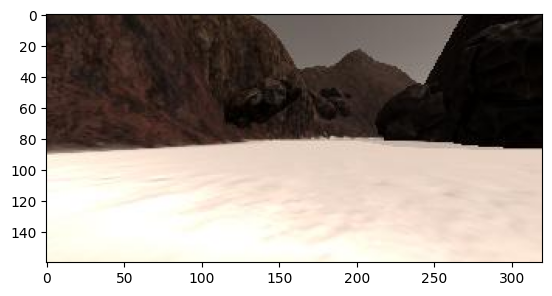

In [6]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

# read and import image

filename = "robocam.jpg"
image = mpimg.imread(filename)
plt.imshow(image)
plt.show()

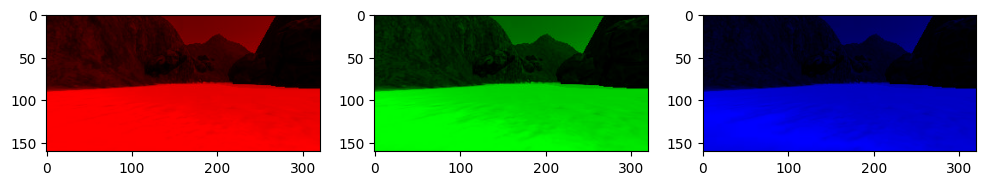

47.41483072916667 43.25189453125 40.310970052083334


In [7]:
import numpy as np
# Note: we use the np.copy() function rather than just saying red_channel = image
# because in Python, such a statement would set those two arrays equal to each other
# forever, meaning any changes made to one would also be made to the other!

filename = "robocam.jpg"
image = mpimg.imread(filename)

red_channel = np.copy(image)
green_channel = np.copy(image)
blue_channel = np.copy(image)

red_channel[:,:,[1,2]] =0 # zero out green and blue
green_channel[:,:,[0,2]] = 0 # zero out red and blue
blue_channel[:,:,[0,1]] = 0 # zero out red andgreen

fig = plt.figure(figsize=(12,3))
plt.subplot(131) #create a subplot grid with 1 row and 3 columns and activate 1st subplt
plt.imshow(red_channel)
plt.subplot(132) #create a subplot grid with 1 row and 3 columns and activate 2nd subplt
plt.imshow(green_channel)
plt.subplot(133) #create a subplot grid with 1 row and 3 columns and activate 3rd subplt
plt.imshow(blue_channel)
plt.show()

print(red_channel.mean(), green_channel.mean(), blue_channel.mean())

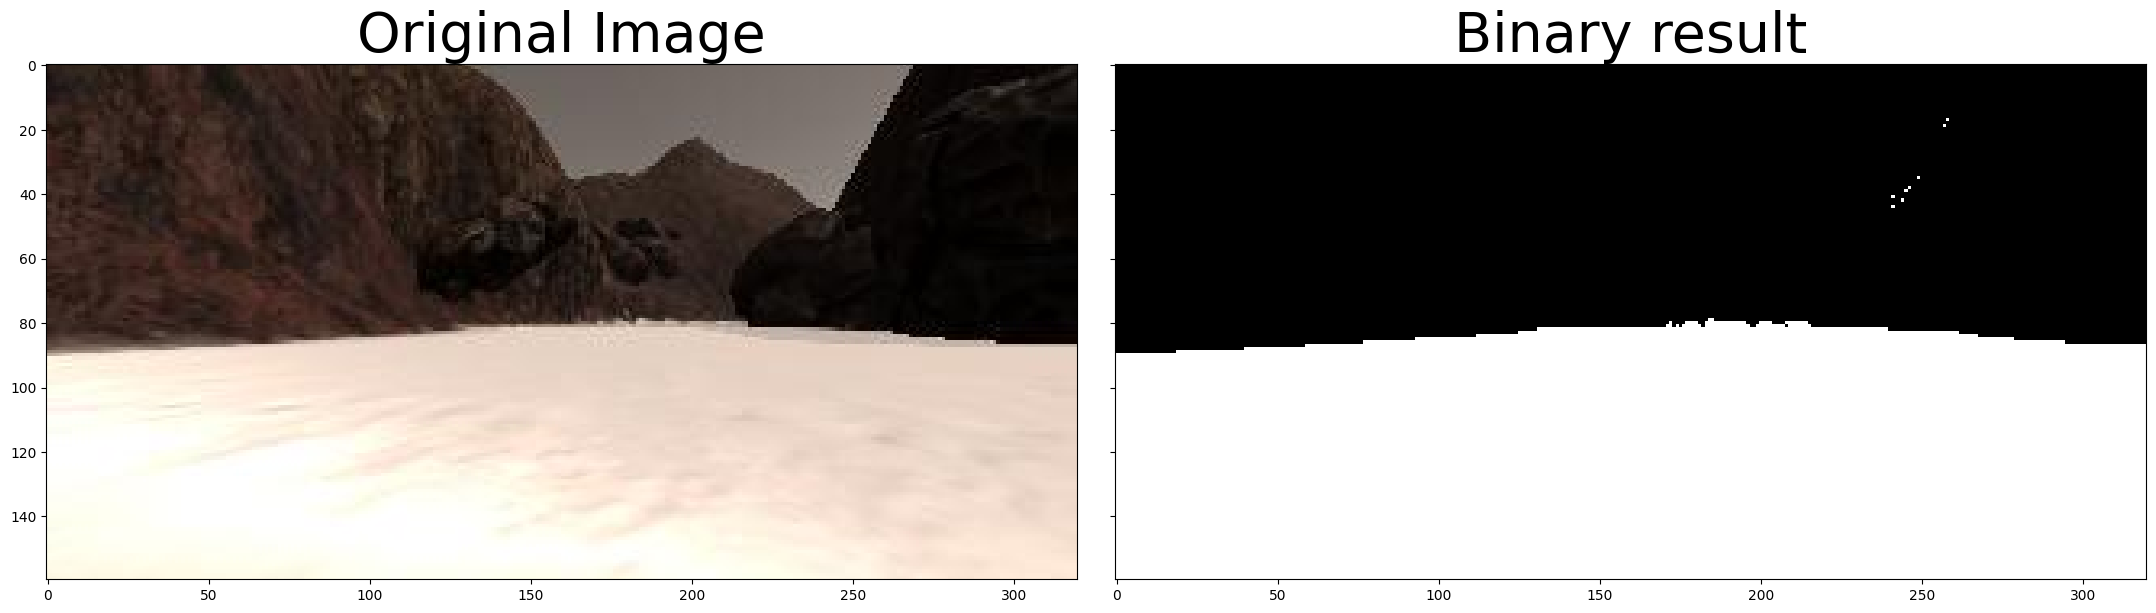

In [8]:
filename = "robocam.jpg"
image = mpimg.imread(filename)

red_thresh = red_channel.mean()
green_thresh = green_channel.mean()
blue_thresh = blue_channel.mean()
####
rgb_threshold= (round(140),round(140),round(140))

def color_thres(img, rgb_thresh=(0,0,0)):
    # Create an empty array the same size in x and y as the image 
    # but just a single channel
    binary_image = np.zeros_like(img[:,:,0])

    above_thresh = (img[:,:,0] > rgb_thresh[0]) \
                &   (img[:,:,1] > rgb_thresh[1] )\
                &   (img[:,:,2] > rgb_thresh[2])
    
    binary_image[above_thresh] = 1


    return binary_image

binary_img = color_thres(image, rgb_thresh=rgb_threshold)

#Display orignal image and binary image
f, (ax1, ax2) = plt.subplots(1,2,figsize=(21,7), sharey=True)
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize = 40)

ax2.imshow(binary_img, cmap = 'grey')
ax2.set_title('Binary result', fontsize = 40)
plt.subplots_adjust(left=0, right=1, top=0.9, bottom=0.)
plt.show()

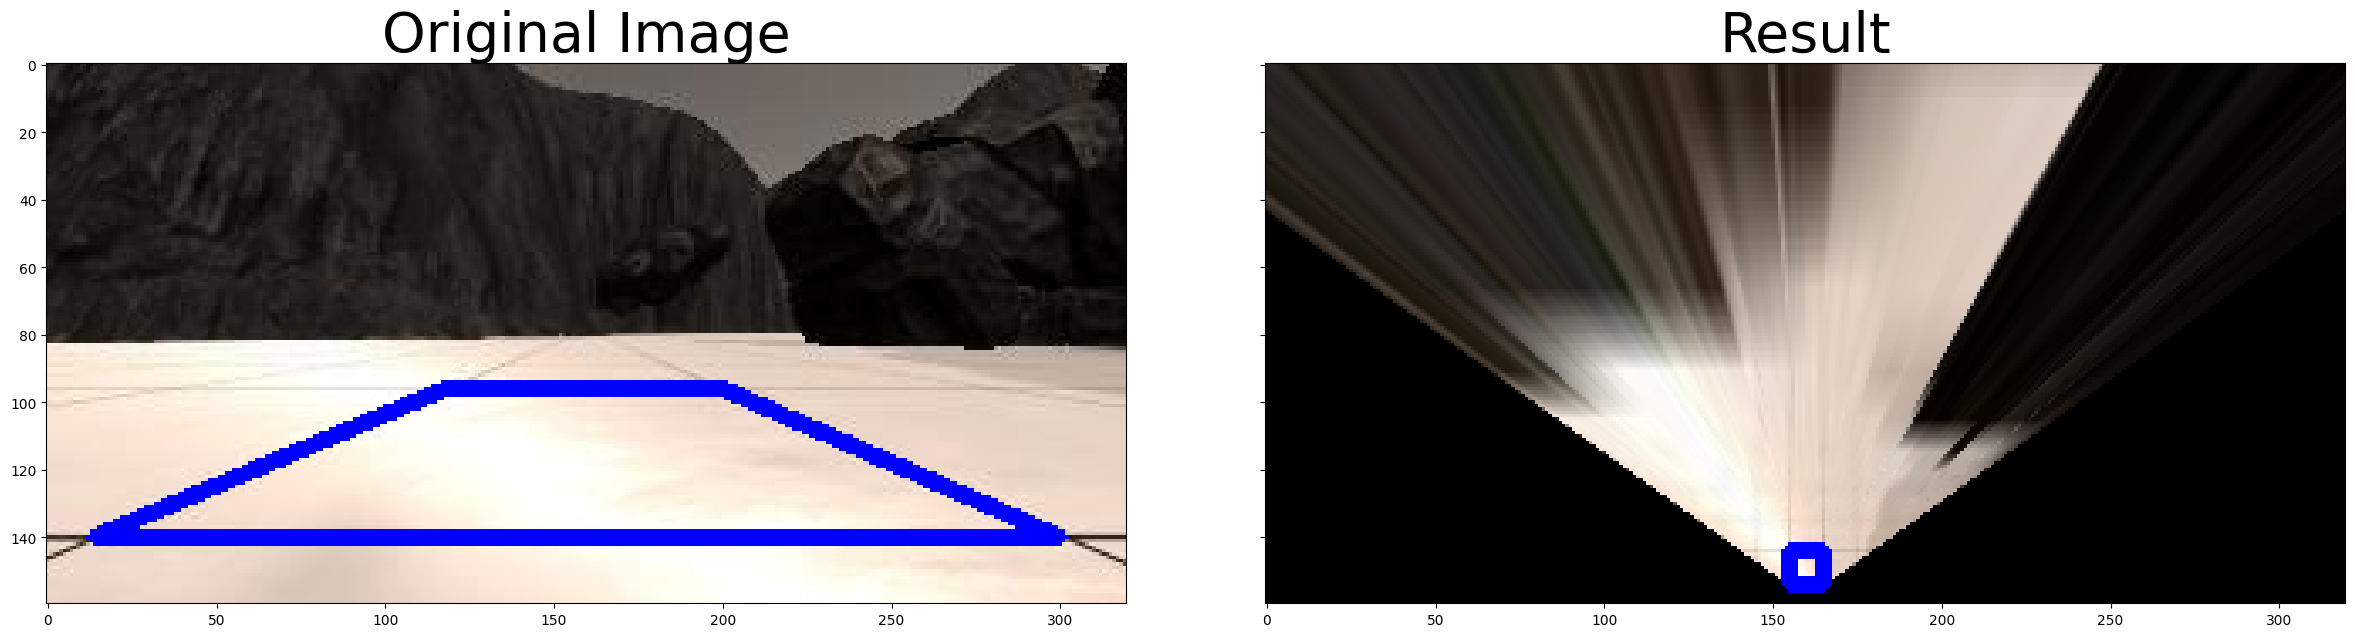

In [9]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2 
import numpy as np
#%matplotlib widget

def perspect_transform(img, src, dst):
    # get the transform matrix using cv2.getPerspectivTransform()
    M = cv2.getPerspectiveTransform(src,dst)
    # Warp image using cv2.warpPerspective()
     # keep same size as input image
    warped = cv2.warpPerspective(img, M, (img.shape[1],img.shape[0]))
    return warped

image = mpimg.imread('example_grid1.jpg')
image = image.copy()
# Define source and destination points
# Define calibration box in source (actual) and destination (desired) coordinates
# These source and destination points are defined to warp the image
# to a grid where each 10x10 pixel square represents 1 square meter
dst_size = 5 
# Set a bottom offset to account for the fact that the bottom of the image 
# is not the position of the rover but a bit in front of it
bottom_offset = 6
source = np.float32([[14 ,140  ], [ 300, 140 ], [ 200, 96 ], [ 118 ,96 ]])
destination = np.float32([[image.shape[1]/2 - dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - 2*dst_size - bottom_offset], 
                  [image.shape[1]/2 - dst_size, image.shape[0] - 2*dst_size - bottom_offset],
                  ])




warped = perspect_transform(image, source, destination)
# Draw Source and destination points on images (in blue) before plotting
cv2.polylines(image, np.int32([source]), True, (0, 0, 255), 3)
cv2.polylines(warped, np.int32([destination]), True, (0, 0, 255), 3)
# Display the original image and binary               
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 6), sharey=True)
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(warped, cmap='gray')
ax2.set_title('Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show() # Uncomment if running on Ir local machine

#### Warp, threshold & Map to Rover-Centric Coordinates
In this section we want to make a map of the environment by applying a perpective transform firstly and then applying a color threshold. Then we convert from raw image to navigable terrain in rover-centric coordinates. 


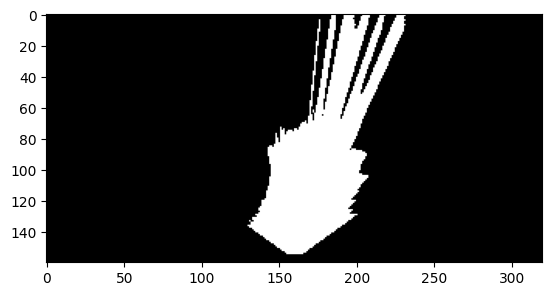

In [10]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# Uncomment the next line for use in a Jupyter notebook
#%matplotlib inline
import numpy as np
import cv2

# Read in the same sample image as before
image = mpimg.imread('robocam.jpg')

# Assume I have already defined perspect_transform() and color_thresh()
warped = perspect_transform(image, source, destination)
colorsel = color_thres(warped, rgb_thresh=(140, 140, 140))

# Plot the result
plt.imshow(colorsel, cmap='gray')
plt.show() 

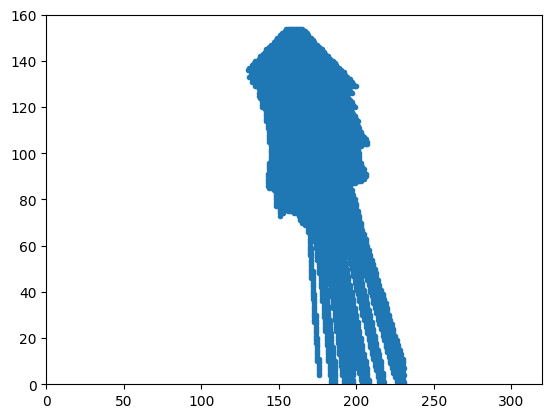

In [11]:
# Next is to extract the pixel positions of all navigable terrain (white) pixels and then transform 
# those values to "rover-centric" coordinates, meaning a coordinate frame where the rover camera 
# is at (x, y) = (0, 0).

ypos, xpos = colorsel.nonzero()
plt.plot(xpos, ypos, '.')
plt.xlim(0, 320)
plt.ylim(0,160)
plt.show()

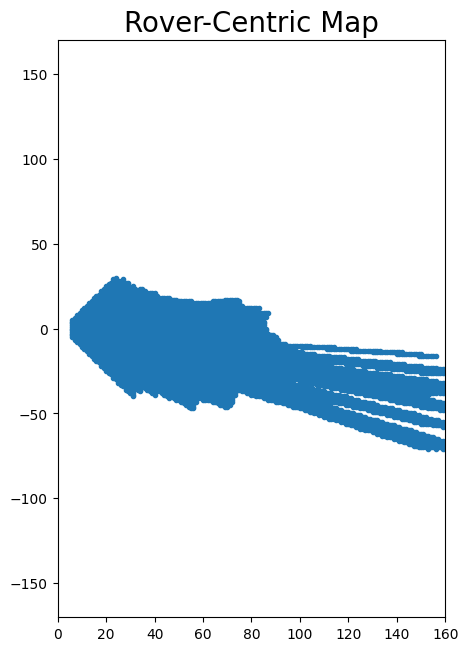

In [12]:
# Now you have x and y pixel positions in image space of the navigable terrain and all you need 
# to do is convert it to rover-centric coordinates. However, you would also like to swap the x 
# and y axes such that they're consistent with the world coordinate system that you'll 
# eventually be mapping to.

image = mpimg.imread('robocam.jpg')

def rover_coord(bin_img):
    xpos , ypos = bin_img.nonzero()
    #calculating the pixel positions with reference to the rover position being at the center 
    # buttom image.
    y_pixel = -(ypos - bin_img.shape[0]).astype(float)
    x_pixel = -(xpos - bin_img.shape[1]/2).astype(float)

    return x_pixel, y_pixel

xpix , ypix = rover_coord(colorsel)

fig = plt.figure(figsize=(5,7.5))
plt.plot(xpix, ypix, '.')
plt.ylim(-170,170)
plt.xlim(0, 160)
plt.title('Rover-Centric Map', fontsize=20)
plt.show() # Uncomment if running on your local machine

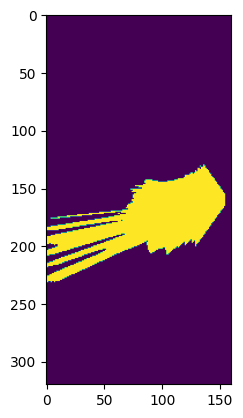

In [13]:
nw = colorsel.transpose()
plt.imshow(nw)
plt.show()

#### Map to the World Coordinates
The goal is to write a code that will allow you to use the rover position, orientation, and camera image to map its environment and compare againt the 
ground truth map


In [14]:
# Now that you have generated a map of navigable terrain in rover-centric 
# coordinates, the next step is to map those points to world coordinates. 
# To do this, you'll use a rotation followed by a translation. The rotation is 
# required to account for the fact that when the camera takes a picture, the rover
# can be pointing in any arbitrary direction, given by it's yaw angle. The 
# translation is to account for the fact that the rover may be located at any 
# position in the world when it takes a picture. So, it's a 2 step process:

# 1.Rotate the rover-centric coordinates so that the x and y axes are parallel to the axes in world space.
# 2.Translate the rotated positions by the x and y position values given by the rover's location (position vector) in the world.

C:\Users\hickm\AppData\Local\Temp\ipykernel_56616\3430170888.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  xpix_translated = int(xpos + (xpix_rot / scale))
C:\Users\hickm\AppData\Local\Temp\ipykernel_56616\3430170888.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ypix_translated = int(ypos + (ypix_rot / scale))


Xpos = [58.25887301] Ypos = [71.05127519] Yaw = [303.13823578]


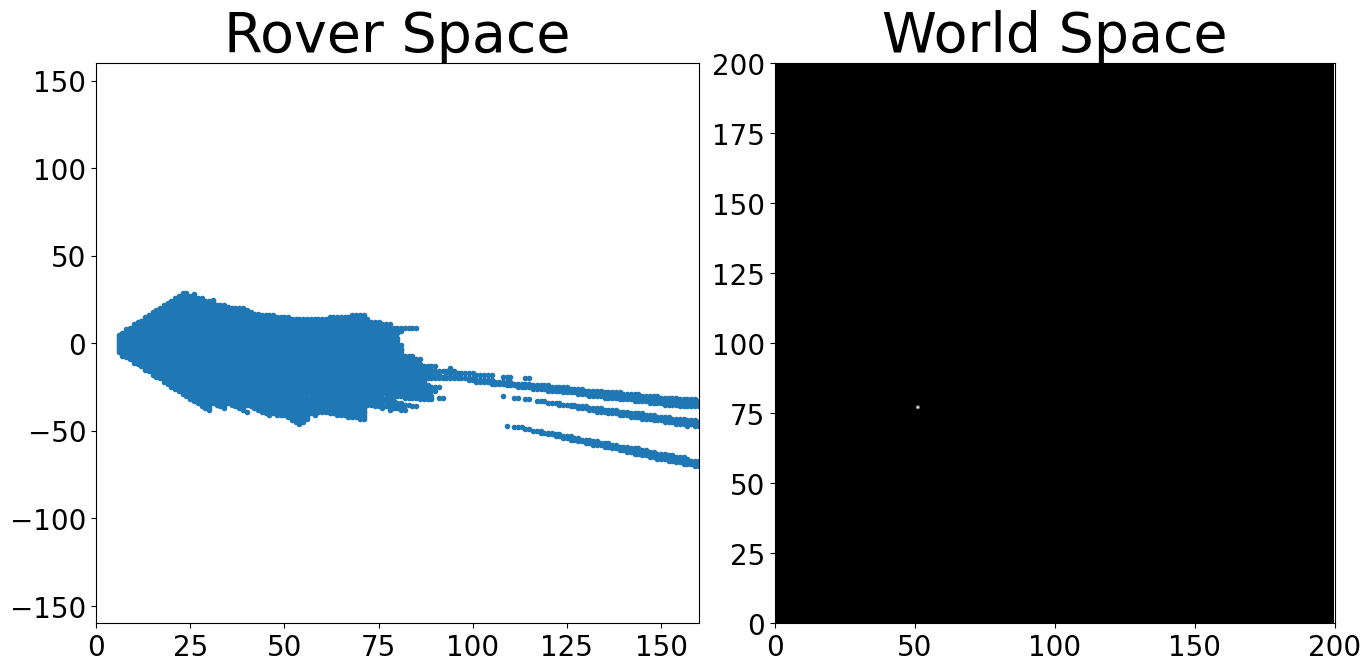

In [15]:
# Rover yaw values will come as floats from 0 to 360
# Generate a random value in this range
# Note: you need to convert this to radians
    # before adding to pixel_angles
rover_yaw = np.random.random(1)*360

# Generate a random rover position in world coords
# Position values will range from 20 to 180 to 
# avoid the edges in a 200 x 200 pixel world
rover_xpos = np.random.random(1)*160 + 20
rover_ypos = np.random.random(1)*160 + 20

# Note: Since we've chosen random numbers for yaw and position, 
# multiple run of the code will result in different outputs each time.

# Define a function to apply a rotation to pixel positions
def rotate_pix(xpix, ypix, yaw):
    # TODO:
    # Convert yaw to radians
    yaw_rad = rover_yaw * np.pi /180
    # Apply a rotation
    xpix_rotated = rover_xpos * np.cos(rover_yaw) - rover_ypos * np.sin(rover_yaw)
    ypix_rotated = rover_xpos * np.sin(rover_yaw) + rover_ypos * np.cos(rover_yaw)
    # Return the result  
    return xpix_rotated, ypix_rotated

# Define a function to perform a translation
def translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale): 
    # TODO:
    # Apply a scaling and a translation
    xpix_translated = int(xpos + (xpix_rot / scale))
    ypix_translated = int(ypos + (ypix_rot / scale))
    # Return the result  
    return xpix_translated, ypix_translated

# Define a function to apply rotation and translation (and clipping)
# Once you define the two functions above this function should work
def pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale):
    # Apply rotation
    xpix_rot, ypix_rot = rotate_pix(xpix, ypix, yaw)
    # Apply translation
    xpix_tran, ypix_tran = translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale)
    # Clip to world_size
    x_pix_world = np.clip(int(xpix_tran), 0, world_size - 1)
    y_pix_world = np.clip(int(ypix_tran), 0, world_size - 1)
    # Return the result
    return x_pix_world, y_pix_world

# Define a function to apply rotation and translation (and clipping)
# Once you define the two functions above this function should work
def pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale):
    # Apply rotation
    xpix_rot, ypix_rot = rotate_pix(xpix, ypix, yaw)
    # Apply translation
    xpix_tran, ypix_tran = translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale)
    # Clip to world_size
    x_pix_world = np.clip(int(xpix_tran), 0, world_size - 1)
    y_pix_world = np.clip(int(ypix_tran), 0, world_size - 1)
    # Return the result
    return x_pix_world, y_pix_world

# No need to modify code below here
# Perform warping and color thresholding
##########
# Define calibration box in source (actual) and destination (desired) coordinates
# These source and destination points are defined to warp the image
# to a grid where each 10x10 pixel square represents 1 square meter
dst_size = 5 
# Set a bottom offset to account for the fact that the bottom of the image 
# is not the position of the rover but a bit in front of it
bottom_offset = 6
source = np.float32([[14, 140], [301 ,140],[200, 96], [118, 96]])
destination = np.float32([[image.shape[1]/2 - dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - 2*dst_size - bottom_offset], 
                  [image.shape[1]/2 - dst_size, image.shape[0] - 2*dst_size - bottom_offset],
                  ])
warped = perspect_transform(image, source, destination)
colorsel = color_thres(warped, rgb_thresh=(160, 160, 160))
# Extract navigable terrain pixels
xpix, ypix = rover_coord(colorsel)
# Generate 200 x 200 pixel worldmap
worldmap = np.zeros((200, 200))
scale = 10
# Get navigable pixel positions in world coords
x_world, y_world = pix_to_world(xpix, ypix, rover_xpos, 
                                rover_ypos, rover_yaw, 
                                worldmap.shape[0], scale)
# Add pixel positions to worldmap
worldmap[y_world, x_world] += 1
print('Xpos =', rover_xpos, 'Ypos =', rover_ypos, 'Yaw =', rover_yaw)
# Plot the map in rover-centric coords

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
f.tight_layout()
ax1.plot(xpix, ypix, '.')
ax1.set_title('Rover Space', fontsize=40)
ax1.set_ylim(-160, 160)
ax1.set_xlim(0, 160)
ax1.tick_params(labelsize=20)

ax2.imshow(worldmap, cmap='gray')
ax2.set_title('World Space', fontsize=40)
ax2.set_ylim(0, 200)
ax2.tick_params(labelsize=20)
ax2.set_xlim(0, 200)


plt.subplots_adjust(left=0.1, right=1, top=0.9, bottom=0.1)
plt.show() # Uncomment if running on your local machine

#### Decision : Where to go

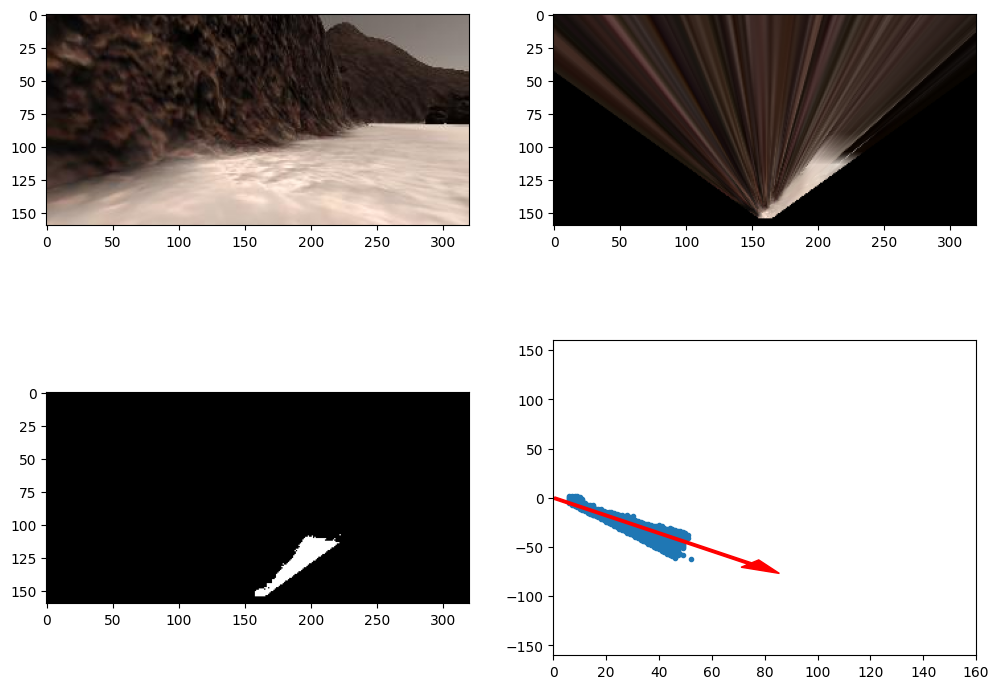

In [16]:
# In this section we want to decide where the robot should go based on the clearest
# path. to control the robot automatically you change parameters like the trottle
# brake, and steering
# Starting with steering, the method we are going to use is to calculate the 
# average angle of the navigable terrian (clearest path)

import numpy as np 
import matplotlib.image as mpimg

# will first convert your (x, y) pixel positions to polar coordinates, where each 
# pixel position is represented by its distance from the origin and angle 
# counterclockwise from the positive x-direction.

def to_polar_coords(xpix, ypix):
    #calc distance to each pixel
    dist = np.sqrt(xpix ** 2 + ypix ** 2)
    # calc angle using arctangent func
    angles = np.arctan2(ypix,xpix)
    return dist , angles

image = mpimg.imread('clear.jpg')
warped = perspect_transform(image, source, destination) # Perform perspective transform
colorsel = color_thres(warped, rgb_thresh=(160, 160, 160)) # Threshold the warped image
xpix, ypix = rover_coord(colorsel)  # Convert to rover-centric coords
distances, angles = to_polar_coords(xpix, ypix) # Convert to polar coords
avg_angle = np.mean(angles) # Compute the average angle

# Do some plotting
fig = plt.figure(figsize=(12,9))
plt.subplot(221)
plt.imshow(image)
plt.subplot(222)
plt.imshow(warped)
plt.subplot(223)
plt.imshow(colorsel, cmap='gray')
plt.subplot(224)
plt.plot(xpix, ypix, '.')
plt.ylim(-160, 160)
plt.xlim(0, 160)
arrow_length = 100
x_arrow = arrow_length * np.cos(avg_angle)
y_arrow = arrow_length * np.sin(avg_angle)
plt.arrow(0, 0, x_arrow, y_arrow, color='red', zorder=2, head_width=10, width=2)
plt.show()

In [17]:
# Given the approximate field of view of the camera, the average values for angle 
# that you get will vary between about +/- \frac{\pi}{4} radians. The input for 
# steering angles you can send to the rover is in degrees over the range -15 (to 
# the right) to +15 (to the left), so the last step is to choose a conversion 
# between your average angle and the steering angle you want to send to the rover.

avg_angle_degrees = avg_angle * 180/np.pi
steering = np.clip(avg_angle_degrees, -15, 15)